In [1]:
# from dist_analy.pypdb import Query, get_pdb_file
from dist_analy.dist_analy import get_shortest_dist_matrix, get_ca_dist_matrix
import dist_analy.import_pdb
import dist_analy.pca
from dist_analy.determine_seq import get_and_align_sequence, get_conserved, get_klifs_res, def_union
from dist_analy.util.pdb_info import pdb_csv, get_any_info, pdb_read_csv
# from dist_analy.alphaspace2.Community import get_community, view_surf_community, view_pocket
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import matplotlib.pylab as pylab
from copy import deepcopy
from Bio import AlignIO
import sklearn
print(sklearn.__version__)

from dist_analy.tree_analysis import TreeNode
from anytree import RenderTree

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

/home/eac709/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


1.3.2


### Get the list of conserved residues across the CDK family

In [4]:
UNIPROT_LIST = ["P06493", "P24941", "Q00526", "P11802", "Q00535", "Q00534", "P50613", "P49336", "P50750", "Q15131", "Q9UQ88", "P21127", "Q9NYV4", \
"Q14004", "O94921", "Q96Q40", "Q00536", "Q00537", "Q07002", "Q9BWU1", "Q8IZL9"]
CDK1_20 = ['CDK1_HUMAN','CDK2_HUMAN','CDK3_HUMAN','CDK4_HUMAN','CDK5_HUMAN','CDK6_HUMAN','CDK7_HUMAN','CDK8_HUMAN','CDK9_HUMAN','CDK10_HUMAN','CD11A_HUMAN','CD11B_HUMAN','CDK12_HUMAN','CDK13_HUMAN','CDK14_HUMAN','CDK15_HUMAN','CDK16_HUMAN','CDK17_HUMAN','CDK18_HUMAN','CDK19_HUMAN','CDK20_HUMAN']

# alignment = get_and_align_sequence('./datafiles/', 'CDK1_20', UNIPROT_LIST, prot_list=CDK1_20)
align = AlignIO.read('./datafiles/align/CDK1_20.al', "clustal")
cons_id = get_conserved(align)

klifs_res = [res for res in get_klifs_res('1FIN','A') if res]
cdk2_klifs_ident, union_id = def_union(cons_id[CDK1_20.index('CDK2_HUMAN')], klifs_res)

### Get the uniprot sequence for each kinase of the CDK family

In [5]:
uniprot_root = 'https://www.ebi.ac.uk/proteins/api/proteins/'
uniprot_seq_cdk2 = get_any_info(uniprot_root, UNIPROT_LIST[CDK1_20.index('CDK2_HUMAN')])["sequence"]["sequence"]

In [6]:
color_list = ['red', 'orange_red_1', 'yellow', 'green_1', 'dark_green', 'cyan', 'blue', 'purple_1b', 'magenta'] ## change to hex code
color_list = ['#e50000', '#f97306', '#ceb301', '#96f97b', '#06470c', '#00ffff', '#0343df', '#7e1e9c', '#cb416b']
cdk2_color_res_list = [np.arange(12,17), np.delete(np.arange(45,58), np.where(np.arange(45,58)==51)), \
              np.arange(80,87), np.delete(np.arange(125,132), np.where(np.arange(125,132)==127)), \
               np.array([33,51,127,145]), np.arange(146,172),np.arange(182,197)]

color_cdk2 = dist_analy.pca.color_text(color_list, cdk2_color_res_list)


### Get all of the PDB structures associated with the CDK2 uniprot ID

In [7]:
cdk2_uniprot = 'P24941'
# editted pypdb to search by uniprot accession ... will need to submit a pull request eventually

found_pdbs = Query(cdk2_uniprot, query_type="uniprot").search()

NameError: name 'Query' is not defined

In [ ]:
outdir = './datafiles/raw_pdb/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
for pdb in found_pdbs:
    pdb_file = get_pdb_file(pdb, filetype='pdb', compression=False)
    fn = outdir + pdb + ".pdb"
    if not os.path.exists(fn):
        with open(fn,'w') as f1:
            f1.write(pdb_file)

In [ ]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'

proc_pdb_list = []
NCAA = ['TPO', 'CSD', 'KCX', 'CSD', 'PTR', 'OCS', 'ALY']
pdb_proc = dist_analy.import_pdb.PDB_Processer(NCAA)
for pdb_fn in found_pdbs:
    pdb_list = pdb_proc.process_pdb(pdb_fn+'.pdb', pdb_dir, proc_dir, cdk2_uniprot)
    for proc in pdb_list:
#         print(proc)
        proc_pdb_list.append(proc)

### Create a .csv file with the characteristics of each of the PDB filesb

In [17]:
csv_dict = pdb_csv(found_pdbs, cdk2_uniprot, "cdk2_pdb.csv")

In [16]:
csv_dict, csv_df = pdb_read_csv("cdk2_pdb.csv")

### calculate the distance matrices

In [ ]:
pdb_dir = './datafiles/raw_pdb/'
proc_dir = './datafiles/proc_pdb/CDK2/'
save_dir = "./datafiles/npy/CDK2/"

dist_mat_list_0 = []
dist_mat_pdb_0 = []
for proc in glob(proc_dir+'*'):
    print(proc)
    pdb = proc.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = get_shortest_dist_matrix(proc, cdk2_klifs_ident, chain, save_dir=save_dir)
    dist_mat_list_0.append(dist_mat)
    dist_mat_pdb_0.append(pdb)

#### if you have the distance matrices already saved, load it in

In [9]:
proc_dir = './datafiles/proc_pdb/CDK2/'
# save_dir = "./datafiles/npy/shortest/CDK2/"
save_dir = "./datafiles/npy/CDK2/"

dist_mat_list_0 = []
dist_mat_pdb_0 = []
for proc in glob(save_dir+'*.npy'):
    print(proc)
    pdb = proc.split('/')[-1].split('.')[0]
    chain = pdb.split(".")[0].split("_")[-1]
    dist_mat = np.load(proc)
    dist_mat_list_0.append(dist_mat)
    dist_mat_pdb_0.append(pdb)

./datafiles/npy/CDK2/4BCM_A.pdb.npy
./datafiles/npy/CDK2/2C5Y_A.pdb.npy
./datafiles/npy/CDK2/2C68_A.pdb.npy
./datafiles/npy/CDK2/1FVT_A.pdb.npy
./datafiles/npy/CDK2/4FKP_A.pdb.npy
./datafiles/npy/CDK2/5UQ1_C.pdb.npy
./datafiles/npy/CDK2/3PY0_A.pdb.npy
./datafiles/npy/CDK2/2BKZ_A.pdb.npy
./datafiles/npy/CDK2/4FKG_A.pdb.npy
./datafiles/npy/CDK2/1OIQ_A.pdb.npy
./datafiles/npy/CDK2/7NVQ_A.pdb.npy
./datafiles/npy/CDK2/3R8V_A.pdb.npy
./datafiles/npy/CDK2/8H6P_A.pdb.npy
./datafiles/npy/CDK2/6YL1_A.pdb.npy
./datafiles/npy/CDK2/3QXO_A.pdb.npy
./datafiles/npy/CDK2/2BPM_C.pdb.npy
./datafiles/npy/CDK2/3PJ8_A.pdb.npy
./datafiles/npy/CDK2/1OIR_A.pdb.npy
./datafiles/npy/CDK2/3QHR_A.pdb.npy
./datafiles/npy/CDK2/4EOP_C.pdb.npy
./datafiles/npy/CDK2/1OI9_C.pdb.npy
./datafiles/npy/CDK2/4FKS_A.pdb.npy
./datafiles/npy/CDK2/2XMY_A.pdb.npy
./datafiles/npy/CDK2/3RPV_A.pdb.npy
./datafiles/npy/CDK2/2B55_A.pdb.npy
./datafiles/npy/CDK2/7RWF_A.pdb.npy
./datafiles/npy/CDK2/1H26_C.pdb.npy
./datafiles/npy/CDK2/1BUH_A.

### observe the frequently missing residues from the distance matrices

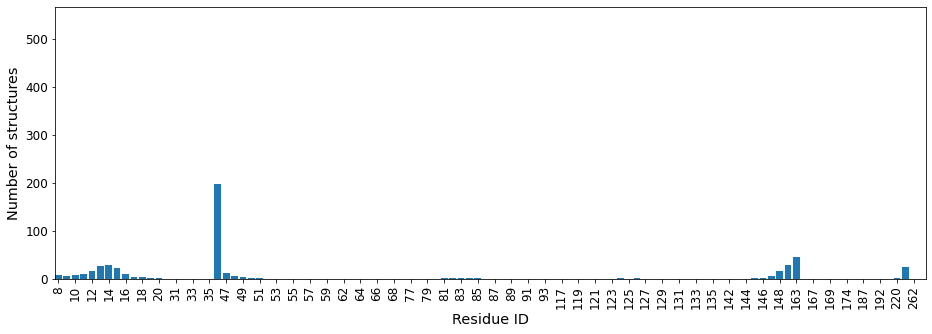

In [10]:
missing_pdb, missing_res = dist_analy.pca.hist_missing_residue(dist_mat_list_0, cdk2_klifs_ident)

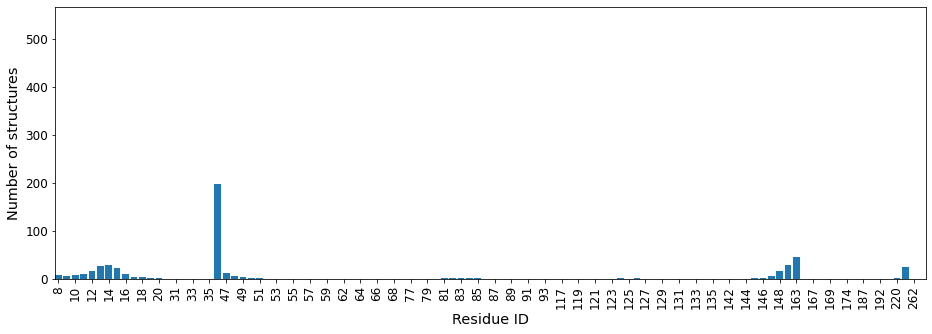

In [11]:
res_get = [145,146,147]
missing_dfg = dist_analy.pca.hist_missing_residue(dist_mat_list_0, cdk2_klifs_ident, res_get)

In [22]:
print(len(dist_mat_list_0))

205


removing residues not available in every structure
original length of residue list 104; remove 34 residues


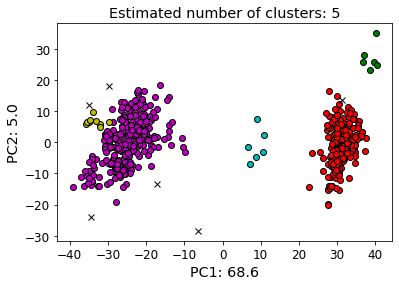

In [13]:
dist_mat_list_0 = np.array(dist_mat_list_0)
proj_0, labels_0, dist_mats_0, res_list_0, ind_list_0, pca_0, hdbscan_0 = dist_analy.pca.run(dist_mat_list_0, cdk2_klifs_ident)
inds_fc_0 = [[j for j,l in enumerate(labels_0) if l==i ] for i in range(min(labels_0),max(labels_0)+1)]

In [17]:
minor_binder_list = []
major_binder_list = []
polymer_binder_list = []
modifications_list = []
# for pdb_chain in [dist_mat_pdb_0[x] for ind_fc in inds_fc_0 for x in ind_fc]:
for pdb_chain in dist_mat_pdb_0:
    pdb = pdb_chain.split('_')[0]
    pdb_dict = csv_dict[pdb]
#     minor_binder_list.append()

    major_binder_list.append(set((pdb_dict['Major Binders'] or []) + (pdb_dict['Minor Binders'] or [])))
    polymer_binder_list.append(pdb_dict['Polymer Binders'])
    modifications_list.append(pdb_dict['Modifications'])

In [19]:
root = TreeNode("All CDK2",num_cluster=6, inds_fc=inds_fc_0)
c1a,c1b,c1c = root.gen_children("Cyclin bound","cyclin",polymer_binder_list,modif=False, not_key=["inhibitor"])

c2a,c2b,c2c=c1a.gen_children("TPO166 modified","tpo",modifications_list,modif=False)
c2d,c2e,c2f=c1c.gen_children("CYS177 modified","csd",modifications_list,modif=False)

c2a.gen_children("ATP/ADP bound",["atp","adp"],major_binder_list,modif=False)
c2c.gen_children("ATP/ADP bound",["atp","adp"],major_binder_list,modif=False)
c2f.gen_children("ATP/ADP bound",["atp","adp"],major_binder_list,modif=False)
            
for pre, _, node in RenderTree(root):
    #print(pre)
    treestr ="%s%s %s %i"%(pre, node.name,node.cluster_count,sum(node.cluster_count))
    print(treestr)

All CDK2 [6, 6, 243, 6, 296, 9] 566
├── Cyclin bound [0, 6, 237, 0, 0, 0] 243
│   ├── TPO166 modified [0, 6, 169, 0, 0, 0] 175
│   │   ├── ATP/ADP bound [0, 0, 28, 0, 0, 0] 28
│   │   ├── Other [0, 5, 125, 0, 0, 0] 130
│   │   └── None [0, 1, 16, 0, 0, 0] 17
│   ├── Other [0, 0, 0, 0, 0, 0] 0
│   └── None [0, 0, 68, 0, 0, 0] 68
│       ├── ATP/ADP bound [0, 0, 2, 0, 0, 0] 2
│       ├── Other [0, 0, 50, 0, 0, 0] 50
│       └── None [0, 0, 16, 0, 0, 0] 16
├── Other [1, 0, 6, 0, 2, 0] 9
└── None [5, 0, 0, 6, 294, 9] 314
    ├── CYS177 modified [0, 0, 0, 0, 12, 0] 12
    ├── Other [1, 0, 0, 0, 51, 0] 52
    └── None [4, 0, 0, 6, 231, 9] 250
        ├── ATP/ADP bound [0, 0, 0, 0, 2, 0] 2
        ├── Other [4, 0, 0, 6, 225, 9] 244
        └── None [0, 0, 0, 0, 4, 0] 4


cluster 3 stabilizing interactions


<span style='color: #f97306'>E57</span>-R122: 2.024, 17.065

<span style='color: #f97306'>L55</span>-<span style='color: #ceb301'>F80</span>: 2.993, 6.670

<span style='color: #f97306'>L55</span>-V64: 3.354, 5.946

<span style='color: #f97306'>L55</span>-I63: 3.488, 4.905

<span style='color: #f97306'>L54</span>-V123: 3.293, 4.165

<span style='color: #f97306'>S53</span>-<span style='color: #f97306'>L54</span>: 2.180, 4.063

cluster 5 stabilizing interactions


<span style='color: #f97306'>S53</span>-V69: 3.034, -5.678

<span style='color: #f97306'>K56</span>-K65: 2.546, -5.270

F117-C118: 2.474, -4.940

<span style='color: #f97306'>K56</span>-L67: 2.755, -4.692

<span style='color: #06470c'>D127</span>-<span style='color: #00ffff'>R169</span>: 2.438, -4.621

<span style='color: #f97306'>K56</span>-D68: 2.817, -4.263

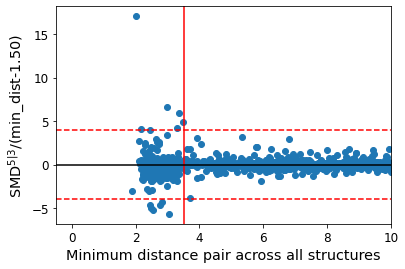

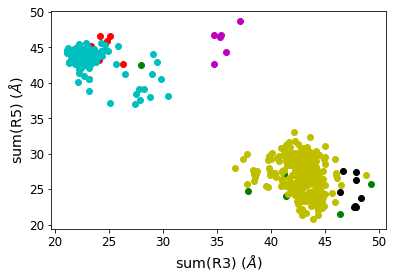

In [21]:
c1 = 4
c2 = 2

feats_0 = dist_analy.pca.triu_flatten(dist_mats_0, len(res_list_0))
uniprot_sequence = 'MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPSTAIREISLLKELNHPNIVKLLDVIHTENKLYLVFEFLHQDLKKFMDASALTGIPLPLIKSYLFQLLQGLAFCHSHRVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFSKVVPPLDEDGRSLLSQMLHYDPNKRISAKAALAHPFFQDVTKPVPHLRL'

smd_0, min_dist_0 = dist_analy.pca.calc_cluster_smd(inds_fc_0[c1], inds_fc_0[c2], feats_0, std = 'SMD')
r1r2_feat_0 = dist_analy.pca.plot_smd(c1, c2, feats_0, min_dist_0, smd_0, [res_list_0], [uniprot_sequence], [color_cdk2], xcutoff=3.5, ycutoff=4, top=25)
dist_analy.pca.plot_r1r2(c1,c2,r1r2_feat_0, inds_fc_0, dist_mats_0)


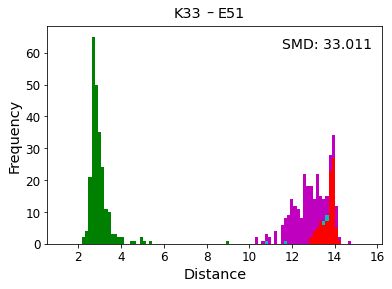

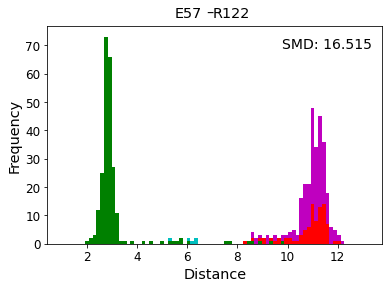

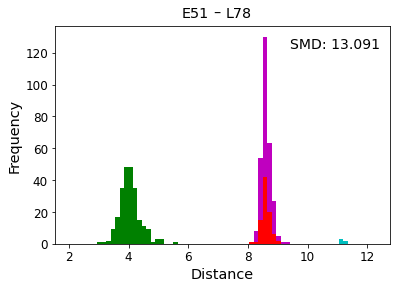

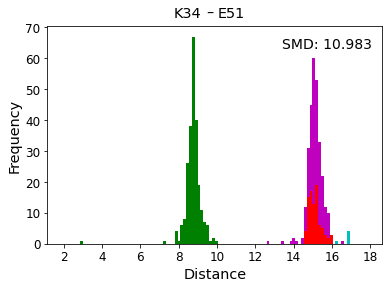

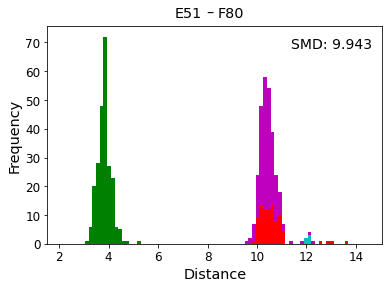

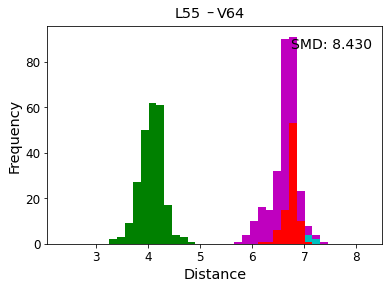

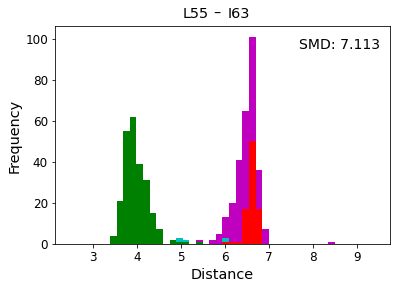

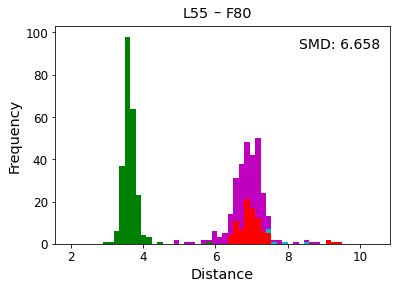

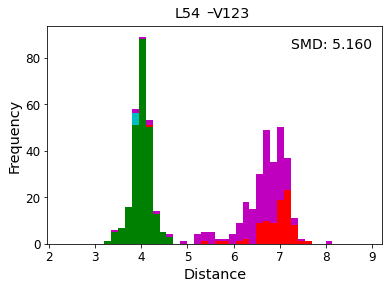

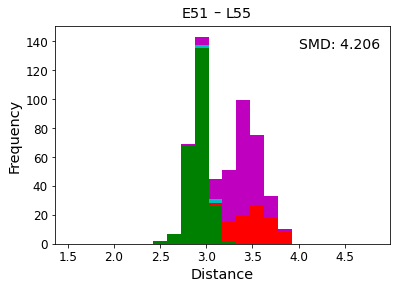

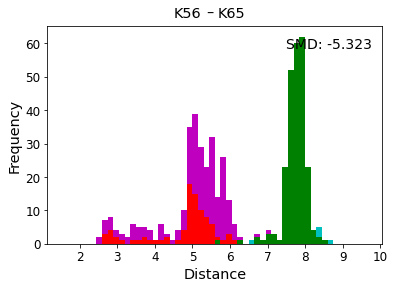

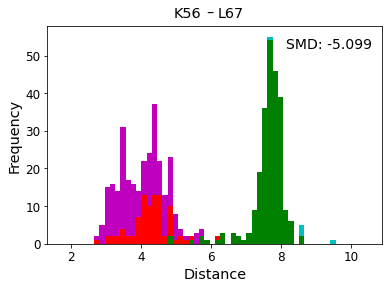

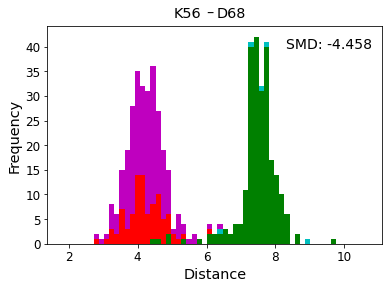

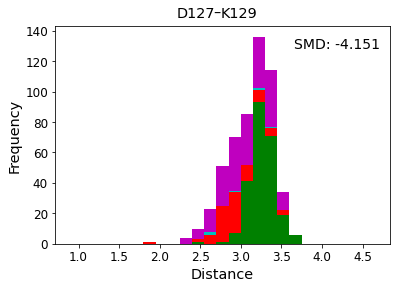

In [31]:
for r1,r2,index, shortest, smd in r1r2_feat_0:
    dist_analy.pca.plot_stacked_histogram(r1,r2,dist_mats_0,[res_list_0],inds_fc_0,[uniprot_seq_cdk2],SMD=smd)